This is an enormous notebook used to generate plots for the CX paper, but also to try explain a little how it works

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy as np
import scipy as sp
from scipy.signal import lfilter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.lines as mlines
import matplotlib.patches as patches

import central_complex as cx

In [2]:
mpl.rc('font', family='Arial', size=14)

In [3]:
nature_single = 89.0 / 25.4
nature_double = 183.0 / 25.4
nature_full = 247.0 / 25.4

outbound_color = 'purple'

label_font_size = 11
unit_font_size = 10

T_inbound = T_outbound = 1000
average_speed = 0.55  # Not exactly but its midpoint between 0.1 and 1.0

## Generating routes

In [4]:
def gen_route(T_outbound=1500, T_inbound=1500, sigma=0.15, min_speed=0.1):
    """Generates a new outbound route"""

    T = T_outbound + T_inbound

    # Create a random change in derivative of the heading function
    # This should make curves smoother as derivative of turns will stay smooth-ish
    heading_delta_delta = np.random.normal(loc=0, scale=sigma, size=T_outbound)
    
    # Decay this derivative towards zero, to avoid too much loopiness
    heading_delta = lfilter([1.0], [1, -0.4], heading_delta_delta)

    # Update heading based on the delta
    heading_outbound = np.cumsum(heading_delta)
    heading_inbound = np.empty(T_inbound) 
    heading_inbound[:] = np.NAN
    heading = np.hstack([heading_outbound, heading_inbound])
    
    speed_outbound = np.max(np.abs(heading_delta)) - np.abs(heading_delta)

    # Run a wide Gaussian filter to simulate speeding up and slowing down for corners
    speed_smoothed = sp.ndimage.filters.gaussian_filter1d(speed_outbound, 20.)
    speed_scaled = min_speed + ((1-min_speed) * (speed_smoothed - np.nanmin(speed_smoothed)) / 
                   (np.nanmax(speed_smoothed) - np.nanmin(speed_smoothed)))
    speed_scaled = np.clip(speed_scaled, 0, 1)

    speed_inbound = np.ones(T_inbound) * (min_speed + 1.0) / 2
    speed = np.hstack([speed_scaled, speed_inbound])

    x = np.hstack([0, np.cumsum(speed * np.cos(heading))])
    y = np.hstack([0, np.cumsum(speed * np.sin(heading))])
    
    return x, y, heading, speed

In [5]:
def run_fast_trial(T_outbound, T_inbound, x, y, heading, speed, c, motor_change=0.5):
    """Follows route and then attempts to go home"""
    
    T = T_outbound + T_inbound
    
    tb1 = np.zeros(8)
    memory = np.ones(16) * 0.5

    # Loop through each time step
    for t in range(1, T):
        # Compass info (current heading as arrived at new location)
        tl2 = c.tl2_output(heading[t-1])
        cl1 = c.cl1_output(tl2)
        tb1 = c.tb1_output(cl1, tb1)

        # Update memory for distance just travelled
        memory = c.cpu4_update(memory, tb1, speed[t-1])
        cpu4 = c.cpu4_output(memory)

        # Generate turn
        cpu1 = c.cpu1_output(tb1, cpu4)
        motor = np.sum(c.motor_output(cpu1))

        # After the final outbound step start updating the heading and checking if home
        if t >= T_outbound and t < T:
            heading[t] = heading[t-1] - motor_change * motor

            x[t+1] = x[t] + np.cos(heading[t]) * speed[t]
            y[t+1] = y[t] + np.sin(heading[t]) * speed[t]
            
    return x, y

In [6]:
def run_trial(T_outbound, T_inbound, x, y, heading, speed, noise=0.1, motor_change=0.5):
    """Follows route and then attempts to go home"""
    
    c = cx.CX(noise=noise)
    T = T_outbound + T_inbound
    
    # Some logs for each cell type
    tl2 = np.zeros([cx.n_tl2, T])
    cl1 = np.zeros([cx.n_cl1, T])
    tb1 = np.zeros([cx.n_tb1, T])
    memory = np.zeros([cx.n_cpu4, T])
    memory[:,0] = 0.5 * np.ones(cx.n_cpu4)
    cpu4 = np.zeros([cx.n_cpu4, T])
    cpu1 = np.zeros([cx.n_cpu1, T])
    motor = np.zeros(T)

    # Loop through each time step
    for t in range(1, T):
        # Compass info (current heading as arrived at new location)
        tl2[:,t] = c.tl2_output(heading[t-1])
        cl1[:,t] = c.cl1_output(tl2[:,t])
        tb1[:,t] = c.tb1_output(cl1[:,t], tb1[:,t-1])

        # Update memory for distance just travelled
        memory[:,t] = c.cpu4_update(memory[:,t-1], tb1[:,t], speed[t-1])
        cpu4[:,t] = c.cpu4_output(memory[:,t])

        # Generate turn
        cpu1[:,t] = c.cpu1_output(tb1[:,t], cpu4[:,t])
        motor[t] = np.sum(c.motor_output(cpu1[:,t]))

        # After the final outbound step start updating the heading and checking if home
        if t >= T_outbound and t < T:
            heading[t] = heading[t-1] - motor_change * motor[t] 

            x[t+1] = x[t] + np.cos(heading[t]) * speed[t]
            y[t+1] = y[t] + np.sin(heading[t]) * speed[t]
            
    return tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y

In [7]:
def plot_route(x, y, T_outbound, T_inbound, plot_speed=False, ax=None, x_lim=None, y_lim=None, legend=True):
    """Plots a route"""
    
    lw =0.5
    T = T_outbound + T_inbound
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12,12))
    else:
        fig = None
        
    if plot_speed:
        speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]), axis=0), 0, 1)
        
        n_min = np.argmin(speed[:T_outbound])
        n_max = np.argmax(speed[:T_outbound])
            
        for i in range(T_outbound-1):
            ax.plot(x[i:i+2], y[i:i+2], color=(speed[i],0.2,1-speed[i]), lw=lw)
            
        blue_line = mlines.Line2D([], [], color='blue', label='Outbound (slow)')
        red_line = mlines.Line2D([], [], color='red', label='Outbound (fast)')
        handles = [blue_line, red_line]
    else:
        line_out, = ax.plot(x[0:T_outbound+1], y[0:T_outbound+1], lw=lw, color=outbound_color, label='Outbound')
        handles = [line_out]
    
    line_in, = ax.plot(x[T_outbound:T], y[T_outbound:T], 'g', lw=lw, label='Return')
    
    handles.append(line_in)
    ax.set_xlabel('Distance (steps)')
    ax.set_ylabel('Distance (steps)')
    ax.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
    ax.set_aspect('equal')
    ax.tick_params(labelsize=unit_font_size)
    
    # Legend
    if legend:
        l = ax.legend(handles=handles,
                      loc='best',
                      fontsize=unit_font_size,
                      handlelength=0,
                      handletextpad=0)
        if plot_speed:
            colors = ['blue', 'red', 'green']
        else:
            colors = ['purple', 'green']
        for i, text in enumerate(l.get_texts()):
            text.set_color(colors[i])
        for handle in l.legendHandles:
            handle.set_visible(False)
        l.draw_frame(False)
        
    return ax, fig

In [8]:
def load_route(filename='route.npz'):
    with np.load(filename) as data:
        tl2 = data['tl2']
        cl1 = data['cl1']
        tb1 = data['tb1']
        memory = data['memory']
        cpu4 = data['cpu4']
        cpu1 = data['cpu1']
        motor = data['motor']
        x = data['x']
        y = data['y']
        T_outbound = data['T_outbound']
        T_inbound = data['T_inbound']
        
    return tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y, T_outbound, T_inbound

Generate a new random route

In [9]:
#x, y, heading, speed = gen_route(T_outbound, T_inbound)
#tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound, T_inbound, x, y, heading, speed)

To add some obstacles

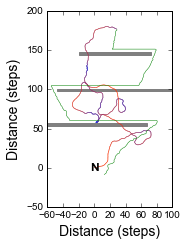

In [13]:
tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y, T_outbound, T_inbound = load_route()
heading = np.arctan2(np.diff(y),np.diff(x))
speed = np.clip(np.linalg.norm(np.vstack([np.diff(x), np.diff(y)]), axis=0), 0, 1)

tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound,
                                                           50,
                                                           x[:T_outbound+51],
                                                           y[:T_outbound+51],
                                                           heading[:T_outbound+50],
                                                           speed)

x = np.hstack([x, np.ones(200) * np.nan])
y = np.hstack([y, np.ones(200) * np.nan])

move_right = x[T_outbound+50] + np.arange(0,101) * average_speed
x[T_outbound+50:T_outbound+151] = move_right
y[T_outbound+50:T_outbound+151] = y[T_outbound+50]
heading = np.arctan2(np.diff(y),np.diff(x))

tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound+150,
                                                           100,
                                                           x[:T_outbound+251],
                                                           y[:T_outbound+251],
                                                           heading[:T_outbound+250],
                                                           speed)

x = np.hstack([x, np.ones(300) * np.nan])
y = np.hstack([y, np.ones(300) * np.nan])

move_left = x[T_outbound+250] + np.arange(0,201) * -1 * average_speed
x[T_outbound+250:T_outbound+451] = move_left
y[T_outbound+250:T_outbound+451] = y[T_outbound+250]
heading = np.arctan2(np.diff(y),np.diff(x))

tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound+450,
                                                           100,
                                                           x[:T_outbound+551],
                                                           y[:T_outbound+551],
                                                           heading[:T_outbound+550],
                                                           speed)

x = np.hstack([x, np.ones(400) * np.nan])
y = np.hstack([y, np.ones(400) * np.nan])

move_left = x[T_outbound+550] + np.arange(0,201) * average_speed
x[T_outbound+550:T_outbound+751] = move_left
y[T_outbound+550:T_outbound+751] = y[T_outbound+550]
heading = np.arctan2(np.diff(y),np.diff(x))

tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound+750,
                                                           200,
                                                           x[:T_outbound+951],
                                                           y[:T_outbound+951],
                                                           heading[:T_outbound+950],
                                                           speed)

fig, ax = plt.subplots(figsize=(nature_single, nature_single))
plot_route(x, y, T_outbound, 950, ax=ax, plot_speed=True, legend=False)

ax.add_patch(
    patches.Rectangle(
        (-20, y[T_outbound+50]-7),
        93,
        3,
        color='gray'
    )
)

ax.add_patch(
    patches.Rectangle(
        (-48, y[T_outbound+250]-7),
        148,
        3,
        color='gray'
    )
)

ax.add_patch(
    patches.Rectangle(
        (-60, y[T_outbound+550]-7),
        128,
        3,
        color='gray'
    )
)
plt.show()

Load the regular route

In [14]:
tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y, T_outbound, T_inbound = load_route()

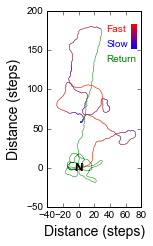

In [15]:
fig, ax = plt.subplots(figsize=(nature_single, nature_single))
plot_route(x, y, T_outbound, T_inbound, ax=ax, plot_speed=True, legend=False)

cdict = {'red':[(0,0,0), (0.5,0.5,0.5), (1,1,1)],
         'green':[(0,0,0), (0.5,0,0), (1,0,0)],
         'blue':[(0,1,1), (0.5,0.5,0.5), (1,0,0)]}
red_blue = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 256)
    
cax = fig.add_axes([0.66, 0.75, 0.02, 0.1])
m = cm.ScalarMappable(cmap=red_blue)
m.set_array(np.linspace(0, 1, 100))
cb = fig.colorbar(m, cax, ticks=[0, 0.2, 0.4, 0.8, 1])
cb.ax.set_yticklabels(['','Slow','','Fast',''])
cb.outline.set_visible(False)
cb.ax.yaxis.set_ticks_position('left')
cax.tick_params(axis='y', which='major', pad=25)
plt.setp(plt.getp(cax, 'yticklabels')[1], color='b', fontsize=unit_font_size, ha='left')
plt.setp(plt.getp(cax, 'yticklabels')[3], color='r', fontsize=unit_font_size, ha='left')
for tic in cb.ax.yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
cax.text(-2.1, -0.4, 'Return', fontsize=unit_font_size, color='g', ha='center', va='center')

In [16]:
def plot_traces(tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y,
                T_outbound, T_inbound, colormap='viridis', title_x=-0.15):
    """Generate big plot with all traces of model. Warning: takes long time to save!!"""
    T = T_outbound + T_inbound
    alpha = 0.2
    titles = ['TL2', 'CL1', 'TB1 (Compass)', 'CPU4 (Memory)', 'CPU1 (Steering)', 'motor']
    data = [tl2, cl1, tb1, cpu4, cpu1, motor]
    dashes = [1, 2, 1, 2]

    fig, ax = plt.subplots(6,1, figsize=(nature_single, nature_single))
    
    for i in range(len(titles)):
        ax[i].set_title(titles[i],
                        x=title_x,
                        y=0.3,
                        va='center',
                        ha='right',
                        fontsize=label_font_size,
                        fontweight='heavy')
        if i == 2:
            ax[i].set_ylabel('Cell indices', fontsize=label_font_size)
        if i < 5:
            p = ax[i].pcolormesh(data[i], vmin=0, vmax=1, cmap=colormap, rasterized=True)
            ax[i].set_xticklabels([])
            ax[i].get_xaxis().set_tick_params(direction='out')

            if i == 2:
                ax[i].set_yticks([1,7])
                ax[i].set_yticklabels([1,8], fontsize=unit_font_size)
            else:
                ax[i].set_yticks([1,14])
                ax[i].set_yticklabels([1,16], fontsize=unit_font_size)
                
            if i == 4:
                fig.savefig('dummy.jpg') # This is needed to force draw the plot
                p.get_facecolors().reshape(16,-1, 4)[:,:T_outbound,3] = 0.1
                p.set_edgecolor('none')
            else:
                p.set_edgecolor('face')
        else:
            ax[i].plot(np.arange(T_outbound),
                       motor[:T_outbound],
                       color=outbound_color,
                       lw=0.5,
                       label='Outbound',
                       alpha=alpha)
            ax[i].plot(np.arange(T_outbound, T),
                       motor[T_outbound:],
                       color='g',
                       lw=0.5,
                       label='Return')
            ax[i].set_xlabel('Time (steps)', fontsize=label_font_size)
            ax[i].set_ylabel('$\Sigma$ activity',
                             labelpad=-1,
                             fontsize=label_font_size)
            ax[i].tick_params(labelsize=unit_font_size)
            ax[i].set_yticks([-2.5, 0, 2.1])
            ax[i].set_yticklabels([-3, 0, 3],
                                  fontsize=unit_font_size)
            ax[i].get_xaxis().set_major_formatter(
                    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            
            dummy_ax = ax[i].twinx()
            dummy_ax.set_ylim([-3, 3])
            dummy_ax.set_yticks([-2.5, 2.1])
            dummy_ax.set_yticklabels(['L','R'],
                                     position=(1.02,0),
                                     fontsize=unit_font_size,
                                     va='center',
                                     ha='center')
            
    # Colorbar
    ax_cb = fig.add_axes([0.92, 0.257, 0.02, 0.643])
    m = cm.ScalarMappable(cmap=colormap)
    m.set_array(np.linspace(0, 1, 100))
    ax_cb.tick_params(labelsize=unit_font_size)
    cb = fig.colorbar(m, ax_cb)
    cb.set_label('Firing rate', size=label_font_size)
    
    # Top spacer
    ax_space = fig.add_axes([0, 0.92, 1, 0.01])
    ax_space.axis('off')
    
    # Dotted bars
    v_indices = np.array([0, 1000, 1300, 2000])
    transFigure = fig.transFigure.inverted()
    for i, v_idx in enumerate(v_indices):
        coord1 = transFigure.transform(ax[0].transData.transform([v_idx,15]))
        coord2 = transFigure.transform(ax[5].transData.transform([v_idx,-3]))
        if i == 0 or i == 3:
            lw=1
            zorder=0
        else:
            lw=1
            zorder=1
        line = mlines.Line2D((coord1[0],coord2[0]),(coord1[1]+0.06,coord2[1]),
                             transform=fig.transFigure, lw=lw, zorder=zorder, c='w', linestyle='dashed')
        line.set_dashes(dashes)
        fig.lines.append(line)
        line = ax[5].axvline(x=v_idx, lw=lw, c='#333333', linestyle='dashed')
        line.set_dashes(dashes)

    # Labels between bars
    label_indices = (v_indices[:3] + v_indices[1:])/2
    labels = ['Outbound', 'Return', 'Search']
    for i, label_idx in enumerate(label_indices):
        ax[0].text(label_idx, 20, labels[i], fontsize=label_font_size, va='center', ha='center')

    return fig, ax

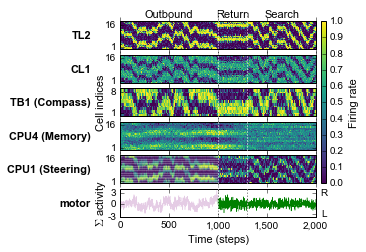

In [17]:
fig, ax = plot_traces(tl2=tl2,
                      cl1=cl1,
                      tb1=tb1,
                      memory=memory,
                      cpu4=cpu4,
                      cpu1=cpu1,
                      motor=motor,
                      x=x,
                      y=y,
                      T_outbound=T_outbound,
                      T_inbound=T_inbound)
plt.show()

## Running Many trials
Running many many trials should give a better idea of performance

In [18]:
def gen_data(N, T_outbound, T_inbound, noise=0.1, sigma=0.15):
    """Generate x, y data for N outbound paths."""
    
    T = T_outbound + T_inbound
    X = np.empty([T+1, N])
    Y = np.empty([T+1, N])
    c = cx.CX(noise=noise)
    
    for i in range(N):
        x, y, heading, speed = gen_route(T_outbound, T_inbound, sigma=sigma)
        X[:,i], Y[:,i] = run_fast_trial(T_outbound,
                                        T_inbound,
                                        x,
                                        y,
                                        heading,
                                        speed,
                                        c)
    return X, Y

In [19]:
def random_walk(N, T_outbound, T_inbound, sigma=0.15):
    """Generate x, y homebound data using same method as outbound route."""
    
    T = T_outbound + T_inbound
    X = np.empty([T, N])
    Y = np.empty([T, N])
    
    for i in range(N):
        x, y, _, _ = gen_route(T_outbound, T_inbound, sigma=sigma)
        x2, y2, _, _ = gen_route(T_outbound, T_inbound, sigma=sigma)
        X[:,i] = np.hstack([x[:T_outbound], x2[:T_outbound]+x[T_outbound]])
        Y[:,i] = np.hstack([y[:T_outbound], y2[:T_outbound]+y[T_outbound]])
        
    return X, Y

## Analysing the data

### Generating a dataset with varying noise

In [22]:
noise_vals = [0, 0.1, 0.2, 0.3, 0.4, 'Random']
N = 10000
T_outbound = T_inbound = 1000

dists = []  # The distance of each homebound x/y location to nest
turn_dists = []  # The distance at which they started to return
min_dists = []  # The closest distance to the nest so far on the return route
x_positions = []
y_positions = []

def run_noise_trials():
    for i, noise_val in enumerate(noise_vals):
        if i < len(noise_vals)-1:
            X, Y = gen_data(N, T_outbound, T_inbound, noise=noise_val)
        else:
            X, Y = random_walk(N, T_outbound, T_inbound)

        np.savez('noise_test_{0}.npz'.format(str(noise_val)),
                     X=X,
                     Y=Y)
#run_noise_trials()

def load_noisy_data():
    for noise_val in noise_vals:
        data = np.load('noise_test_{0}.npz'.format(str(noise_val)))
        X = data['X']
        x_positions.append(X)
        
        Y = data['Y']
        y_positions.append(Y)
        
        d = np.sqrt(X[T_outbound:,:]**2 + Y[T_outbound:,:]**2)
        dists.append(d)
        
        turn_dists.append(d[0,:])
        min_dists.append(np.nanmin(d, axis=0))
        
load_noisy_data()

### How well is the agent aiming towards home?

After 20 steps on the return path we check what the angular offset is between a vector from release point to current location and the true heading from release point to nest.

The y axis of this plot is $\log(number\ of\ trials)$

In [23]:
def polar_homing_angle(X, Y, T_outbound, ax, color=None, bins=360):
    bin_count = bins
    N = X.shape[1]

    nest_angles = np.arctan2(-X[T_outbound,:], -Y[T_outbound,:])
    return_angles = np.arctan2(X[T_outbound+20,:] - X[T_outbound,:],
                               Y[T_outbound+20,:] - Y[T_outbound,:])
    angular_distance = (nest_angles - return_angles + np.pi) % (2 * np.pi) - np.pi

    radii = np.histogram(angular_distance, np.linspace(-np.pi-np.pi/bin_count,
                                                       np.pi+np.pi/bin_count,
                                                       bin_count+2,
                                                       endpoint=True))[0]
    radii[0] += radii[-1]
    radii = radii[:-1]
    radii = np.roll(radii, bin_count/2)
    radii = np.append(radii, radii[0])
    radii[radii == 0] = 1  # Need this hack to get the plot fill to work reliably
    
    theta = np.linspace(0, 2 * np.pi, bin_count+1, endpoint=True)

    ax.plot(theta, radii, color=color, alpha=0.5)
    if color:
        ax.fill_between(theta, 0, radii, alpha=0.2, color=color)
    else:
        ax.fill_between(theta, 0, radii, alpha=0.2)

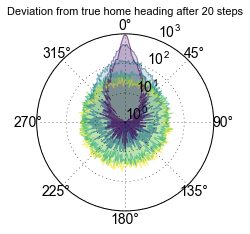

In [24]:
colors = [cm.viridis(x) for x in np.linspace(0, 1, len(noise_vals))]

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(nature_single,nature_single))

for i in reversed(range(len(noise_vals))):
    X = x_positions[i]
    Y = y_positions[i]
    polar_homing_angle(X, Y, T_outbound, ax, colors[i], bins=360)

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlabel_position(22)
ax.set_title('Deviation from true home heading after 20 steps', y=1.08, fontsize=label_font_size)

ax.set_rscale('log')
ax.set_rlim(0.0, 1001)

plt.tight_layout()

### How straight is the route home?

To see how straight the route, we compare the distance travelled and distance remaining to the nest to an ideal route back (straight home). Blue area shows std.

In the second plot it's worth noting that acutually the performance is (even) more reliable than shown but is dragged down by routes that happen to start very close to the nest

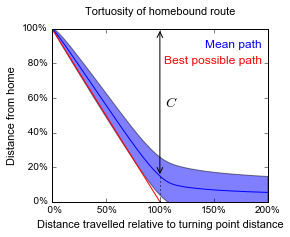

In [25]:
cum_min_dist = np.minimum.accumulate(dists[1] / turn_dists[1])  # Just at noise 0.1

mu = cum_min_dist.mean(axis=1)
sigma = cum_min_dist.std(axis=1)
t = np.arange(len(mu))

fig, ax = plt.subplots(figsize=(nature_single*1.2, nature_single))

x_count = 500
av_speed = 0.55

# Here we interpolate to normalise all return routes relative to their nest distance
cum_min_dist_norm = np.vstack([np.interp(np.linspace(0, turn_dists[1][i]/av_speed*2, x_count, endpoint=False),
                                         t,
                                         cum_min_dist[:,i]) for i in np.arange(N)]).T

mu2 = np.nanmean(cum_min_dist_norm, axis=1)
sigma2 = np.nanstd(cum_min_dist_norm, axis=1)

t2 = np.linspace(0, 2, x_count)
ax.plot(t2, mu2, label='Mean path')
ax.fill_between(t2, mu2+sigma2, mu2-sigma2, facecolor='blue', alpha=0.5)
ax.set_ylim(0,1)
ax.plot([0, 1], [1,0], 'r', label='Best possible path')
ax.set_xlabel('Distance travelled relative to turning point distance', fontsize=label_font_size)
ax.set_ylabel('Distance from home', fontsize=label_font_size)
ax.set_title('Tortuosity of homebound route', y=1.05, fontsize=label_font_size)

vals = ax.get_xticks()
ax.set_xticklabels(['{:3.0f}%'.format(x*100) for x in vals])

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
ax.tick_params(labelsize=unit_font_size)

ax.axvline(x=1, ymin=0, ymax=mu2[250], color='black', linestyle='dotted')

ax.annotate(s='',
            xy=(1, mu2[250]),
            xytext=(1,1),
            arrowprops=dict(facecolor='black',
                            arrowstyle='<->'))

ax.text(1.05, mu2[250]+(1-mu2[250])/2, '$C$', fontsize=14, color='k', ha='left', va='center')


l = ax.legend(loc='best', prop={'size':12}, handlelength=0, handletextpad=0)
colors = ['blue', 'red']
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[i])
    text.set_ha('right') # ha is alias for horizontalalignment
    text.set_position((103,0))
for handle in l.legendHandles:
    handle.set_visible(False)
l.draw_frame(False)

plt.tight_layout()

We can calculate the tortuosity using the most basic formula: $$\tau = L / C$$

In [26]:
tort = 1.0 / (1.0 - mu2[250])
print "Tortoisity for mean homebound path up to 1 route length of steps is", tort

Tortoisity for mean homebound path up to 1 route length of steps is 1.17318894484


An example of a failed route due to noisy neurons

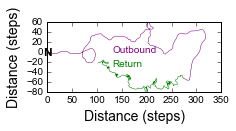

In [27]:
T_outbound = 1000
T_inbound = 1000

x, y, heading, speed = gen_route(T_outbound, T_inbound)
tl2, cl1, tb1, memory, cpu4, cpu1, motor, x, y = run_trial(T_outbound,
                                                           T_inbound,
                                                           x,
                                                           y,
                                                           heading,
                                                           speed,
                                                           noise=0.3)
fig, ax = plt.subplots(figsize=(nature_single, nature_single))
plot_route(x, y, T_outbound, T_inbound, ax=ax, plot_speed=False)
plt.tight_layout()

### How does distance affect homing?

An example of a failed route due to memory saturation

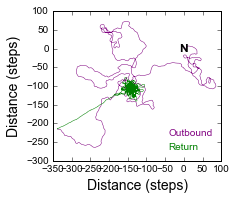

In [28]:
T_outbound = 5000
T_inbound = 5000

x, y, heading, speed = gen_route(T_outbound, T_inbound)
x, y = run_fast_trial(T_outbound, T_inbound, x, y, heading, speed, cx.CX())
fig, ax = plt.subplots(figsize=(nature_single, nature_single))
plot_route(x, y, T_outbound, T_inbound, ax=ax, plot_speed=False)

plt.tight_layout()

### How close does the agent get with varying noise and distance

varying route distance at different noise levels and also compared to just a random walk on the homebound path.

In [29]:
N = 1000
N_dists = 20
distances = np.round(10 ** np.linspace(1, 4, N_dists)).astype('int')
noise_vals = [0.0, 0.1, 0.2, 0.3, 0.4, 'Random']
colors = [cm.viridis(x) for x in reversed(np.linspace(0, 1, len(noise_vals)))]

def noise_v_distance():
    for noise_val in noise_vals:
        dists = []
        turn_dists = []
        min_dists = []

        print noise_val
        for i, distance in enumerate(distances):
            if noise_val != 'Random':
                X, Y = gen_data(N, distance, distance, noise=noise_val)
            else:
                X, Y = random_walk(N, distance, distance)
            d = np.sqrt(X[distance:,:]**2 + Y[distance:,:]**2)    
            dists.append(d)
            turn_dists.append(d[0,:])
            min_dists.append(np.nanmin(d, axis=0))

        np.savez('distances_{0}.npz'.format(str(noise_val)),
                 dists=dists,
                 turn_dists=turn_dists,
                 min_dists=min_dists)
        
#noise_v_distance()

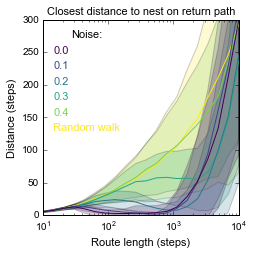

In [31]:
fig, ax = plt.subplots(figsize=(nature_single, nature_single))

for i, noise_val in enumerate(reversed(noise_vals)):
    data = np.load('distances_{0}.npz'.format(str(noise_val)))
    min_dists, turn_dists = data['min_dists'], data['turn_dists']
    
    mu = [np.mean(d) for d in min_dists]
    sigma = [np.std(d) for d in min_dists]
    if i > 0:
        ax.semilogx(distances, mu, color=colors[i], label=noise_val, lw=1);
    else:
        ax.semilogx(distances, mu, color=colors[i], label='Random walk', lw=1);
    ax.fill_between(distances, 
                    [m+s for m, s in zip(mu, sigma)], 
                    [m-s for m, s in zip(mu, sigma)],
                    facecolor=colors[i], alpha=0.2);
    
ax.set_xlim(10, 10000)
ax.set_ylim(0, 300)
ax.set_title('Closest distance to nest on return path', fontsize=label_font_size)
ax.tick_params(labelsize=unit_font_size)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Noise')
ax.set_xlabel('Route length (steps)', fontsize=label_font_size)
ax.set_ylabel('Distance (steps)', fontsize=label_font_size)

handles, labels = ax.get_legend_handles_labels()

l = ax.legend(reversed(handles),
              reversed(labels),
              loc='best',
              fontsize=label_font_size,
              handlelength=0,
              handletextpad=0,
              title='Noise:')
l.get_title().set_fontsize(label_font_size)
for i, text in enumerate(l.get_texts()):
    text.set_color(colors[5-i])
for handle in l.legendHandles:
    handle.set_visible(False)
l.draw_frame(False)